In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.svm import SVR
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder,OneHotEncoder
from sklearn.linear_model import Ridge,Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import StackingRegressor


In [2]:
#data = pd.read_csv('../data/data.csv')
data= pd.read_csv('../data/data_engineered.csv')
data.head()
data.shape

(312, 41)

In [14]:
# Define features (X) and target variable (y)

# columns to exclude: population-related and crime-related features
crime_related_columns = [
    'count:__crimes_against_society', 
    'count:__fraud_and_other_financial_crimes', 
    'count:__property_crime', 
    'count:__violent_crime',
    'rate:__crimes_against_society', 
    'rate:__fraud_and_other_financial_crimes', 
    'rate:__property_crime', 
    'rate:__violent_crime',
    'total_crime_count',
    'total_crime_rate',
    'log_total_crime_rate'
]

population_related_columns = [
    'total_pop',
    'white_pop',
    'black_pop',
    'hispanic_pop',
    'asian_pop',
    'native_pop',
    'islander_pop',
    'multi_race_pop',
    'state'
]

#features to keep: exclude population-related and crime-related features
#X = data.drop(columns=crime_related_columns + population_related_columns)
X = data.drop(columns=crime_related_columns + population_related_columns)
# Display the list of features used for modeling
filtered_features = X.columns.tolist()
print(filtered_features)

y = data['log_total_crime_rate']

['year', 'median_income', 'poverty_rate', 'unemployment_rate', 'unemployed_15_weeks', 'labor_force_participation_rate', 'hs_grad_rate', 'bachelors_grad_rate', 'zhvi', 'crude_rate_suicide', 'crude_rate_od', 'youth_not_in_school', 'youth_in_foster_care', 'youth_living_in_poverty', 'youth_school_poverty_interaction', 'poverty_income_interaction', 'unemployment_youth_interaction', 'poverty_rate_squared', 'median_income_squared', 'poverty_to_income_ratio', 'youth_to_total_pop_ratio']


In [ ]:
## Train test split

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, test_size = 0.2)


print(f'X_train shape: {X_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'y_test shape: {y_test.shape}')

X_train shape: (249, 21)
X_test shape: (63, 21)
y_train shape: (249,)
y_test shape: (63,)


### Gradient Boost

In [19]:


# Pipeline setup
gb_pipeline = Pipeline(steps=[
   #('preprocessor', column_transformer),
    ('gb', GradientBoostingRegressor(random_state=42))
])

# Fit the pipeline to the training data
gb_pipeline.fit(X_train, y_train)
print(X_train.shape)
# Predict on training and testing data
y_train_pred = gb_pipeline.predict(X_train)
y_test_pred = gb_pipeline.predict(X_test)

# Calculate training and testing scoresa
train_mse = mean_squared_error(y_train, y_train_pred)
train_mae = mean_absolute_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)

test_mse = mean_squared_error(y_test, y_test_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)


print("Training MSE:", train_mse)
print("Training MAE:", train_mae)
print("Training R²:", train_r2)

print("Testing MSE:", test_mse)
print("Testing MAE:", test_mae)
print("Testing R²:", test_r2)

(249, 21)
Training MSE: 0.05342694555473656
Training MAE: 0.17434637883254206
Training R²: 0.9559703892775199
Testing MSE: 0.7628857612436972
Testing MAE: 0.5760191132934017
Testing R²: 0.46015897306560893


In [ ]:
### Hypertune Gradient Boost

In [21]:
#

# Define the parameter grid for Gradient Boosting
param_grid = {
    'gb__n_estimators': [200, 300,400,500],
    'gb__max_depth': [3, 4],
    'gb__learning_rate': [0.01, 0.05, 0.1,0.2,0.3],
    'gb__min_samples_split': [2, 5, 10,15],
    'gb__min_samples_leaf': [1, 2, 4],
    'gb__subsample': [0.6, 0.8, 1.0]
}

# Setup GridSearchCV with the pipeline and parameter grid
grid_search = GridSearchCV(gb_pipeline, param_grid=param_grid, cv=5, scoring='r2', n_jobs=-1, verbose=1)

# Fit GridSearchCV on the training data
grid_search.fit(X_train, y_train)

# Best parameters from grid search
best_params = grid_search.best_params_
best_score = grid_search.best_score_ 

print("Best Parameters:", best_params)
print("Best Cross-Validated MSE:", best_score)


Fitting 5 folds for each of 1440 candidates, totalling 7200 fits


/opt/anaconda3/lib/python3.11/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best Parameters: {'gb__learning_rate': 0.05, 'gb__max_depth': 4, 'gb__min_samples_leaf': 1, 'gb__min_samples_split': 15, 'gb__n_estimators': 500, 'gb__subsample': 0.6}
Best Cross-Validated MSE: 0.241951012024677


In [34]:
# Predict on training and testing data
best_model = grid_search.best_estimator_
print(best_model)
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)


# Calculate training and testing scores
train_mse = mean_squared_error(y_train, y_train_pred)
train_mae = mean_absolute_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)

test_mse = mean_squared_error(y_test, y_test_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)
#print("Training Scores:")
#print(f"MSE: {train_mse}, MAE: {train_mae}, R2: {train_r2}")

#print("\nTesting Scores:")
#print(f"MSE: {test_mse}, MAE: {test_mae}, R2: {test_r2}")


#print("\nCross-Validation Scores (averaged across 5 folds):")
#print(f" R2: {np.mean(cv_r2)}")
print("Best Parameters:", best_params)
print("Best Cross-Validated R²:", best_score)
print("Training MSE:", train_mse)
print("Training MAE:", train_mae)
print("Training R²:", train_r2)
print("Testing MSE:", test_mse)
print("Testing MAE:", test_mae)
print("Testing R²:", test_r2)


Pipeline(steps=[('gb',
                 GradientBoostingRegressor(learning_rate=0.05, max_depth=4,
                                           min_samples_split=15,
                                           n_estimators=500, random_state=42,
                                           subsample=0.6))])
Best Parameters: {'gb__learning_rate': 0.05, 'gb__max_depth': 4, 'gb__min_samples_leaf': 1, 'gb__min_samples_split': 15, 'gb__n_estimators': 500, 'gb__subsample': 0.6}
Best Cross-Validated R²: 0.241951012024677
Training MSE: 0.0016082758174038962
Training MAE: 0.03310221261884295
Training R²: 0.9986746059045781
Testing MSE: 0.810493450023562
Testing MAE: 0.6209370214958719
Testing R²: 0.42647033328945605


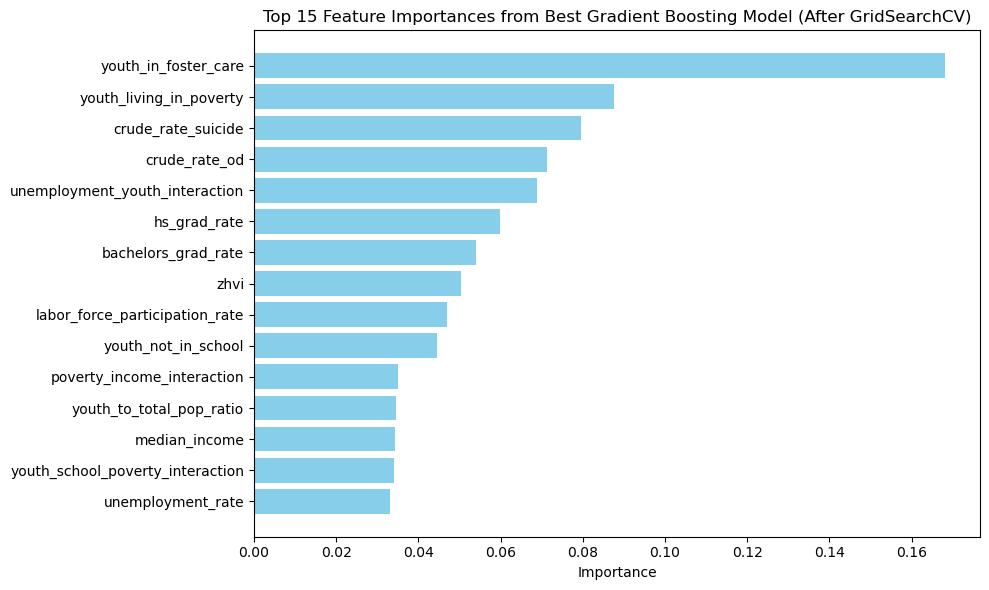

In [36]:

feature_importances = best_model.named_steps['gb'].feature_importances_

# Combine feature names and their corresponding importances
feature_importance_df = pd.DataFrame({
    'feature': X_train.columns,
    'importance': feature_importances
}).sort_values(by='importance', ascending=False)

# Plot the feature importances in a graph
plt.figure(figsize=(10, 6))

# Select the top 15 features for visualization
top_features = feature_importance_df.head(15)
plt.barh(top_features['feature'], top_features['importance'], color='skyblue')
plt.xlabel('Importance')
plt.title('Top 15 Feature Importances from Best Gradient Boosting Model (After GridSearchCV)')
plt.gca().invert_yaxis()  # Invert y-axis for better readability

plt.tight_layout()


###  XG Boosting

In [38]:
# Pipeline setup
xg_pipeline = Pipeline(steps=[
    #('preprocessor', column_transformer),
    ('scaler', StandardScaler()),
    ('xgb', XGBRegressor(random_state=42, alpha=1.5))
])


# Training the base model
xg_pipeline.fit(X_train, y_train)

# Making predictions on training and testing sets
y_train_pred = xg_pipeline.predict(X_train)
y_test_pred = xg_pipeline.predict(X_test)

# Evaluating the model on training, validation, and testing sets
mse_train = mean_squared_error(y_train, y_train_pred)
mae_train = mean_absolute_error(y_train, y_train_pred)
r2_train= r2_score(y_train, y_train_pred)


mse_test = mean_squared_error(y_test, y_test_pred)
mae_test= mean_absolute_error(y_test, y_test_pred)
r2_test = r2_score(y_test, y_test_pred)



print("Training MSE:", mse_train)
print("Training MAE:", mae_train)
print("Training R²:", r2_train)
print("Testing MSE:", mse_test)
print("Testing MAE:", mae_test)
print("Testing R²:", r2_test)



Training MSE: 0.016934874243996957
Training MAE: 0.08193913123490523
Training R²: 0.9860438227779009
Testing MSE: 0.7310156293856678
Testing MAE: 0.5972730163203257
Testing R²: 0.48271124181253755


###  HyperTune XG Boosting

In [40]:


# Define the parameter grid
# Define parameter grid for hyperparameter tuning
param_grid = {
    'xgb__n_estimators': [100, 200],
    'xgb__learning_rate': [0.01, 0.05, 0.1],
    'xgb__max_depth': [3, 5],
    'xgb__subsample': [0.8, 0.9, 1.0],
    'xgb__colsample_bytree': [0.7, 0.8, 1.0],
    'xgb__lambda': [0, 1, 10],       # L2 regularization
    'xgb__alpha': [0, 0.5, 1]        # L1 regularization
}

# Set up GridSearchCV
grid_search = GridSearchCV(
    xg_pipeline,
    param_grid=param_grid,
    cv=5,                             # 5-fold cross-validation
                    
    n_jobs=-1,                        # Use all available cores
   
)

# Fit GridSearchCV to the training data
# Fit with early stopping
grid_search.fit(
    X_train, y_train,
 
)


# Retrieve best parameters and score
best_params = grid_search.best_params_
best_score = grid_search.best_score_
best_model = grid_search.best_estimator_

y_train_pred = grid_search.best_estimator_.predict(X_train)
y_test_pred = grid_search.best_estimator_.predict(X_test)
# Evaluate the best model on the test set
train_mse = mean_squared_error(y_train, y_train_pred)
train_mae = mean_absolute_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)


print("Best Parameters:", best_params)
print("Best Cross-Validated R²:", best_score)
print("Training MSE:", train_mse)
print("Training MAE:", train_mae)
print("Training R²:", train_r2)
print("Testing MSE:", test_mse)
print("Testing MAE:", test_mae)
print("Testing R²:", test_r2)

/opt/anaconda3/lib/python3.11/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best Parameters: {'xgb__alpha': 0, 'xgb__colsample_bytree': 0.7, 'xgb__lambda': 1, 'xgb__learning_rate': 0.1, 'xgb__max_depth': 5, 'xgb__n_estimators': 200, 'xgb__subsample': 0.9}
Best Cross-Validated R²: 0.2843593019606949
Training MSE: 6.882846928991822e-05
Training MAE: 0.006044357467456948
Training R²: 0.9999432778595521
Testing MSE: 0.8384643716082705
Testing MAE: 0.626504416034902
Testing R²: 0.40667726360629175


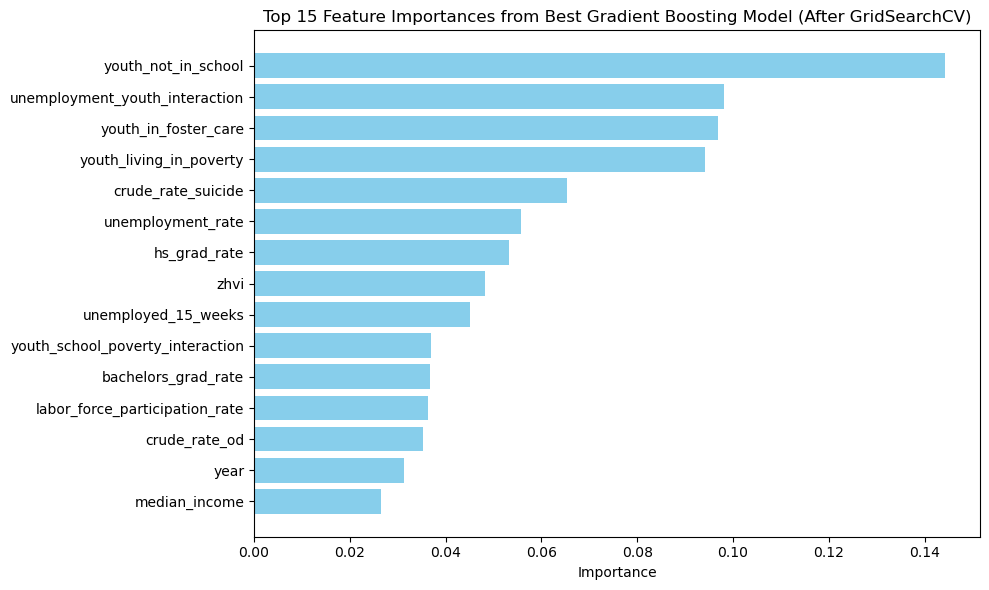

In [41]:
 #Get feature importances from the best model (Gradient Boosting)
feature_importances = best_model.named_steps['xgb'].feature_importances_

# Combine feature names and their corresponding importances
feature_importance_df = pd.DataFrame({
    'feature': X.columns,
    'importance': feature_importances
}).sort_values(by='importance', ascending=False)

# Plot the feature importances in a graph
plt.figure(figsize=(10, 6))
feature_importance_df.head(15)
# Select the top 15 features for visualization
top_features = feature_importance_df.head(15)
plt.barh(top_features['feature'], top_features['importance'], color='skyblue')
plt.xlabel('Importance')
plt.title('Top 15 Feature Importances from Best Gradient Boosting Model (After GridSearchCV)')
plt.gca().invert_yaxis()  # Invert y-axis for better readability

plt.tight_layout()
plt.show()

### SVM

In [42]:


# Define the SVM pipeline with scaling
svm_pipeline = Pipeline([
    #('preprocessor', column_transformer),
    ('scaler', StandardScaler()),       # Scale features for SVR
    ('svr', SVR(kernel='linear',C=1.0, epsilon=0.1)   ) # Basic SVR model with default parameters
])


# Fit the pipeline on the training data
svm_pipeline.fit(X_train, y_train)

# Make predictions on training and testing sets

y_train_pred = svm_pipeline.predict(X_train)
y_test_pred = svm_pipeline.predict(X_test)

# Evaluate the model performance
train_mse = mean_squared_error(y_train, y_train_pred)
train_mae = mean_absolute_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)

test_mse = mean_squared_error(y_test, y_test_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)
test_r2_log = r2_score(y_test, y_test_pred)



print("Training MSE:", train_mse)
print("Training MAE:", train_mae)
print("Training R²:", train_r2)
print("Testing MSE:", test_mse)
print("Testing MAE:", test_mae)
print("Testing R²:", test_r2)


Training MSE: 1.0460998043062424
Training MAE: 0.583667286190142
Training R²: 0.1379000487071067
Testing MSE: 1.953817441901354
Testing MAE: 0.9132650585204491
Testing R²: 0.40667726360629175


In [43]:
# Fit your model
X_train_df = pd.DataFrame(X_train, columns=X.columns)



# Access the coefficients (assuming SVR model in a regression task)
coefficients = svm_pipeline.named_steps['svr'].coef_[0]  # For SVR, coef_ is usually in a nested array

# If using LinearSVC for classification, the approach is similar:
# coefficients = svm_pipeline.named_steps['linear_svc'].coef_[0]

# Associate each coefficient with its corresponding feature name
features = X_train_df.columns  # Ensure this matches the columns input to the model after any preprocessing
feature_importance = pd.DataFrame(coefficients, index=features, columns=['Coefficient'])

# Display the feature importances
print(feature_importance.sort_values(by='Coefficient', ascending=False))


                                  Coefficient
youth_not_in_school                  0.603555
poverty_rate                         0.481412
median_income_squared                0.300776
crude_rate_suicide                   0.149700
unemployment_rate                    0.080662
youth_in_foster_care                 0.050167
hs_grad_rate                         0.032240
year                                 0.023128
bachelors_grad_rate                  0.014883
youth_to_total_pop_ratio             0.007696
crude_rate_od                       -0.003702
youth_living_in_poverty             -0.035441
labor_force_participation_rate      -0.057014
unemployed_15_weeks                 -0.062602
zhvi                                -0.102358
youth_school_poverty_interaction    -0.104915
poverty_income_interaction          -0.128985
poverty_rate_squared                -0.275059
poverty_to_income_ratio             -0.338484
median_income                       -0.456399
unemployment_youth_interaction    

### Hypertune SVM

In [44]:



# Define the parameter grid for GridSearchCV
param_grid = {
    'svr__C': [0.1, 1, 10],              # Regularization strength
    'svr__epsilon': [0.01, 0.1, 0.5],    # Insensitivity margin
    'svr__kernel': ['linear', 'rbf']      # Kernels to test
}

# Set up GridSearchCV with cross-validation
grid_search = GridSearchCV(svm_pipeline, param_grid, cv=5, scoring='r2', verbose=1, n_jobs=-1)

# Fit GridSearchCV to the training data
grid_search.fit(X_train, y_train)

# Retrieve the best parameters and score
best_params = grid_search.best_params_
best_score = grid_search.best_score_
best_model = grid_search.best_estimator_
# Make predictions with the best estimator on the test set
y_train_pred = grid_search.best_estimator_.predict(X_train)
y_test_pred= grid_search.best_estimator_.predict(X_test)

# Evaluate the model on the test set
train_mse = mean_squared_error(y_train, y_train_pred)
train_mae = mean_absolute_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

print("Best Parameters:", best_params)
print("Best Cross-Validated R²:", best_score)

print("Training MSE:", train_mse)
print("Training MAE:", train_mae)
print("Training R²:", train_r2)
print("Testing MSE:", test_mse)
print("Testing MAE:", test_mae)
print("Testing R²:", test_r2)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best Parameters: {'svr__C': 10, 'svr__epsilon': 0.01, 'svr__kernel': 'rbf'}
Best Cross-Validated R²: 0.3605187940403211
Training MSE: 0.2993007576193192
Training MAE: 0.16446458243808798
Training R²: 0.7533436413013567
Testing MSE: 1.1067689401916845
Testing MAE: 0.6507547419849462
Testing R²: 0.2168168399445234


### Stacking

In [46]:


# Define base models and meta model
base_models = [
    ('gradient_boosting', GradientBoostingRegressor(learning_rate=0.05, max_depth=4, n_estimators=500, random_state=42,min_samples_leaf= 1,min_samples_split= 5)),
    ('random_forest', RandomForestRegressor(ccp_alpha=0.1,n_estimators=50, max_depth=7,random_state=42,min_samples_leaf= 4,min_samples_split= 8)),
   ('lasso', Lasso(alpha=0.1, max_iter=10000))
]


meta_model = Ridge(alpha=1.0)


# Define the stacking regressor
stacked_ensemble = StackingRegressor(estimators=base_models, final_estimator=meta_model, cv=5)

# Create pipeline with stacking ensemble
stacking_pipeline = Pipeline(steps=[
    #('preprocessor', column_transformer),
    ('scaler', StandardScaler()),
    ('stacked_model', stacked_ensemble)
])

# Fit GridSearchCV on the training data to find the best parameters
stacking_pipeline.fit(X_train, y_train)


# Evaluate the stacked model on the test data
y_train_pred = stacking_pipeline.predict(X_train)
y_test_pred= stacking_pipeline.predict(X_test)

ensemble_train_score = stacking_pipeline.score(X_train, y_train)
ensemble_test_score = stacking_pipeline.score(X_test, y_test)

# Evaluate the model on the test set
train_mse = mean_squared_error(y_train, y_train_pred)
train_mae = mean_absolute_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)


print("Training MSE:", train_mse)
print("Training MAE:", train_mae)
print("Training R²:", train_r2)
print("Testing MSE:", test_mse)
print("Testing MAE:", test_mae)
print("Testing R²:", test_r2)

Training MSE: 0.24455128648148214
Training MAE: 0.3293890870443391
Training R²: 0.7984631568647336
Testing MSE: 0.826766186071282
Testing MAE: 0.6536348370462185
Testing R²: 0.41495525333212113


In [53]:
from sklearn.ensemble import BaggingRegressor

# Initialize XGBoost Regressor
xgb_regressor = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=3)

# Set up Bagging with XGBoost as the base estimator
bagging_xgb = BaggingRegressor(
    estimator=xgb_regressor,
    n_estimators=10,          # Number of XGBoost models in the ensemble
    max_samples=0.8,          # Fraction of data used for each bootstrapped sample
    max_features=1.0,         # Fraction of features used for each model
    bootstrap=True,           # Bootstrapping samples
    n_jobs=-1,                # Use all processors
    random_state=42
)

# Train the bagging ensemble
bagging_xgb.fit(X_train, y_train)

# Make predictions
y_pred = bagging_xgb.predict(X_test)

# Calculate RMSE for evaluation
mse = r2_score(y_test, y_pred)
print(f'Bagging XGBoost MSE: {mse}')


Bagging XGBoost MSE: 0.28356401190525204


### Multi Target Regressor 

In [59]:
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.ensemble import RandomForestRegressor
# Define features and target

# columns to exclude: population-related and crime-related features
crime_related_columns = [
    'count:__crimes_against_society', 
    'count:__fraud_and_other_financial_crimes', 
    'count:__property_crime', 
    'count:__violent_crime',
    'rate:__crimes_against_society', 
    'rate:__fraud_and_other_financial_crimes', 
    'rate:__property_crime', 
    'rate:__violent_crime',
    'total_crime_count',
    'total_crime_rate',
    'log_total_crime_rate'
]

population_related_columns = [
    'total_pop',
    'white_pop',
    'black_pop',
    'hispanic_pop',
    'asian_pop',
    'native_pop',
    'islander_pop',
    'multi_race_pop',
    'state'
]

#features to keep: exclude population-related and crime-related features
#X = data.drop(columns=crime_related_columns + population_related_columns)
X = data.drop(columns=crime_related_columns + population_related_columns)
# Display the list of features used for modeling
filtered_features = X.columns.tolist()
print(filtered_features)

y = data['log_total_crime_rate']
target_features = ['rate:__crimes_against_society', 
    'rate:__fraud_and_other_financial_crimes', 
    'rate:__property_crime', 
    'rate:__violent_crime']

X = data.drop(columns=crime_related_columns+population_related_columns )
y =np.log1p(data[target_features]) 

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

# Predicting multiple outputs
y_pred = model.predict(X_test)
# Evaluate the model
r_squared_each_output = r2_score(y_test, y_pred, multioutput='raw_values')



print("R^2 Score for each target:", r_squared_each_output)


['year', 'median_income', 'poverty_rate', 'unemployment_rate', 'unemployed_15_weeks', 'labor_force_participation_rate', 'hs_grad_rate', 'bachelors_grad_rate', 'zhvi', 'crude_rate_suicide', 'crude_rate_od', 'youth_not_in_school', 'youth_in_foster_care', 'youth_living_in_poverty', 'youth_school_poverty_interaction', 'poverty_income_interaction', 'unemployment_youth_interaction', 'poverty_rate_squared', 'median_income_squared', 'poverty_to_income_ratio', 'youth_to_total_pop_ratio']
R^2 Score for each target: [0.39933367 0.34326616 0.37723664 0.31650861]
